## **Simulações numéricas 3D em GPUs de hipertermia com nanopartículas por um modelo de bioaquecimento não linear**

Nome: Lucas Martins Oliveira

# **Motivação**

Temos que o câncer de um modo geral é um problema de saúde mundial e afeta milhares de pessoas todos anos, dessa forma uma forma menos invasiva que vem sendo adotada são as terapias térmicas, já que essas vem apresentando ótimos resultados devido a sua  capacidade de aquecimento de diferentes tecidos e em áreas localizadas, assim temos vários “métodos”, como a terapia baseada em radiação eletromagnética, as baseadas em campos magnéticos alternados  de baixa frequência e a hipertermia por meio de nanopartículas que vai ser o nosso alvo de estudo

De um modo geral, a hipertermia com nanopartículas pode ser usada como um tratamento minimamente invasivo para destruir tumores em tecidos vivos.O objetivo é aquecer o tumor até um limiar de temperatura acima do fisiológico normal, a fim de destruir suas células por necrose,mantendo o mínimo possível o dano do tecido saudável, na qual esse tratamento não só destroi as celulas tumorais por conta do aquecimento provocado como também gera uma indução da resposta imune

Equação a ser modelada:

\begin{equation*}
  \begin{cases}
    \displaystyle \nabla \cdot k \nabla T + w_b c_b(T_a - T) + Q_m = 0 \text{ para } \Omega\\\\
    \displaystyle k \nabla T \cdot\vec{n} = 0 \text{ para } \partial \Omega_N\\\\
    \displaystyle T  = 37 \text{ para } \partial \Omega_D\\\\
    \displaystyle T(.,0) = 37
  \end{cases}
\end{equation*}

\begin{equation*}
  \text { onde } T : \Omega \times  I \rightarrow \mathbb{R^+} \text { representa o campo de temperatura do tecido } \\
  c_b : \Omega \times  I \rightarrow \mathbb{R^+} \text { representa o calor específico do sangue } \\
  k : \Omega \times  I \rightarrow \mathbb{R^+} \text { na qual a condutividade térmica é considerada isotrópica, mas não homogênea } \\
  w_b:  \Omega \times {R^+} \times  I \rightarrow \mathbb{R^+} \text { taxa de perfusão sanguínea } \\
  T_a \text { temperatura arterial } \\
  Q_m : \Omega \times  I \rightarrow \mathbb{R^+} \text { representa a geração de calor metabólico } \\
  f : \Omega \times  I \rightarrow \mathbb{R^+} \text { temperaturaprescrita(Dirichelet) ou fluxo (Neumann ou Robin} \\
  \alpha , \beta : \Omega \times  I \rightarrow \mathbb{R^+} \text { sendo o vetor normal unitário } \\
\end{equation*}

In [1]:
# DOLFIN is the computational backend of the FEniCS project
import numpy as np
try:
    from dolfin import *
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenics-install.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"
    from dolfin import *

In [60]:
mesh = RectangleMesh(Point(0.0, 0.0), Point(50.0, 100.0), 50, 100)
V = FunctionSpace(mesh, 'P', 1)
materials = MeshFunction('size_t',mesh,mesh.topology().dim())

Definindo as 4 possibilidades de tecido, que vão ser utilizados em algumas das variáveis:



---



0. Derme
1. Gordura
2. Musculo
3. Tumor


In [61]:
tol = 1E-14

class Dermis(SubDomain):
    def inside(self, x, on_boundary):
        return x[0] <= 2 + tol

class Fat(SubDomain):
    def inside(self, x, on_boundary):
        return x[0] > 2 - tol and x[0] <= 12 + tol

class Muscle(SubDomain):
    def inside(self, x, on_boundary):
        return x[0] > 12 - tol and x[0] <= 50 + tol

class Tumor(SubDomain):
    def inside(self, x, on_boundary):
        return (x[0]-32)**2 + (x[1]-50)**2 <= 12**2

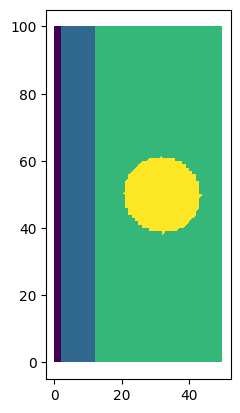

In [62]:
subdomain_0 = Dermis()
subdomain_1 = Fat()
subdomain_2 = Muscle()
subdomain_3 = Tumor()
subdomain_0.mark(materials, 0)
subdomain_1.mark(materials, 1)
subdomain_2.mark(materials, 2)
subdomain_3.mark(materials, 3)

plot(materials)

In [63]:
V0 = FunctionSpace(mesh, 'DG', 0)
scale=0.01

A geração de calor metabólico varia de acordo com a região tratada, temos assim então:

\begin{equation*}
  Q_{m_{muscle}} = Q_{m_{fat}} = Q_{m_{dermis}} = 420.0 \\
  Q_{m_{tumor}} = 4200.0
\end{equation*}

In [64]:
qm_values = [420, 420, 420, 4200]  # values of qm in the two subdomains

Temos que a condutividade térmica varia de acordo com o tecido, assim obtemos a seguintes relações:

\begin{equation*}
  k_{dermis} = 0.40\\
  k_{fat} = 0.21\\
  k_{muscle} = 0.45\\
  k_{tumor} = 0.55\\
\end{equation*}

In [65]:
k_values = [0.4, 0.21, 0.45, 0.55]  # values of k in the two subdomains

In [66]:
elem = FiniteElement("CG", triangle, 1) # here interval is a FEniCS builtin representing a single interval
W = FunctionSpace(mesh, elem)

V = TestFunction(W) # the test function
T = TrialFunction(W) # the TrialFunction is basically a symbol representing the unknown

A taxa de perfusão sanguínea varia de acordo com o tecido e com a temperatura que esse se encontra, dessa forma temos que:

\begin{equation*}
  W_{dermis} = 0.5 \\
  W_{muscle} =
    \begin{cases}
      \displaystyle 0.45 + 3.55exp(-\frac{(T-45.0)^2}{12.0}) \text { para } T \leq 45.0 \\\\
      4.0 \text { para } T>45.0
    \end{cases} \\
    W_{fat} =
    \begin{cases}
      \displaystyle 0.36 + 0.36exp(-\frac{(T-45.0)^2}{12.0}) \text { para } T \leq 45.0 \\\\
      0.72 \text { para } T>45.0
    \end{cases} \\
    W_{tumor} =
    \begin{cases}
      \displaystyle 0.833 + -\frac{(T-37.0)^{4.8}}{5.438E+3} \text { para } 37.0 \leq T \leq 42.0 \\\\
      0.416 \text { para } T>42.0
    \end{cases} \\
\end{equation*}

In [98]:
import numpy as np
U_sol = Function(W)  # place to store the solution


fat = (0.36 + 0.36*np.exp((-(40-45.0)**2)/12)) * 1
muscle = 0.45 + 3.55*np.exp((-(40-45.0)**2)/12) * 1
tumor =0.833 - ((40-37)**4.8)/(5438)

w_values = [0.5, fat, muscle, tumor]  # values of wb in the two subdomains


In [99]:
#declarando os vetores
qm  = Function(V0)
k  = Function(V0)
w  = Function(V0)

# a  = Function(V0)
# b  = Function(V0)
# c  = Function(V0)
# d  = Function(V0)
# e  = Function(V0)


# a_values = [0.5, 0.36, 0.45, 0.833]
# b_values = [0, 0.36, 3.55, 0]
# c_values = [0, 45, 45, 0]
# d_values = [1, 12, 12, 1]
# e_values = [1, 2, 2, 1]

#Percorremos o dominio diferenciando os respectivos tecidos e os valores das variaveis de acordo com cada regiao
for cell_no in range(len(materials.array())):
    subdomain_no = materials.array()[cell_no]

    qm.vector()[cell_no] = qm_values[subdomain_no] #valores de qm
    k.vector()[cell_no] = k_values[subdomain_no] #valores de k
    w.vector()[cell_no] = k_values[subdomain_no] #valores de w
    # a.vector()[cell_no] = a_values[subdomain_no]
    # b.vector()[cell_no] = b_values[subdomain_no]
    # c.vector()[cell_no] = c_values[subdomain_no]
    # d.vector()[cell_no] = d_values[subdomain_no]
    # e.vector()[cell_no] = e_values[subdomain_no]


Reorganizando a equação para o método :

\begin{equation*}
  \int_{\Omega}^{} \nabla k \nabla T V dx - \int_{\Omega}^{} w_b c_b T V dx  = - \int_{\Omega}^{} Q_m V dx - \int_{\Omega}^{} w_b c_b T_a V dx
\end{equation*}

No qual denominamos $a(u,v)$ igual a:

\begin{equation*}
  \int_{\Omega}^{} \nabla k \nabla T V dx - \int_{\Omega}^{} w_b c_b T V dx
\end{equation*}

Já a outra expressão que não trabalha com a variação da temperatura diretamente, isolamos a no lado direito como mostrado anteriormente e denominamos esse lado como $f$:

\begin{equation*}
  - \int_{\Omega}^{} Q_m V dx - \int_{\Omega}^{} w_b c_b T_a V dx
\end{equation*}

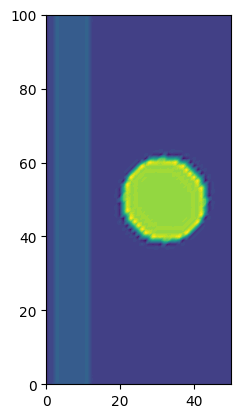

In [100]:
cb = Constant(4200.0) # calor especifico do sangue
Ta = Constant(37.0) # temperatura arterial

#a = (U*V)/dt * dx + kappa * dot( grad(U), grad(V) ) * dx  # left hand side of our equation
a = (dot( k* grad(T), grad(V) ) * dx) - (w * cb * T)*V*dx

#é o que chamamos de f, isolamos do lado direito
L = (-qm - w*cb*Ta)*V*dx # right hand side of our equation


value_left = Constant(37.0)

bc_l = DirichletBC(W, value_left, "on_boundary && near(x[0], 0)") # Imposing Dirichlet BC to the left boundary node


bcs = [bc_l]   # list of boundary conditions to apply to the problem

f = File("results.pvd")


solve(a == L, U_sol, bcs)
plot(U_sol);
f<<U_sol

